# Investigating Biodiversity Intactness Index change in Phoenix subdivision


### Context
In 2021, Maricopa County, which encompasses the Phoenix metropolitan area, was the US county that added the most developed land since 2001 [1](https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/). Urban sprawl creates pressure on biodiversity and natural areas. In this notebookk I will explore a dataset showing values for a biodiversity intactness index (BII) [2](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf), [3](https://planetarycomputer.microsoft.com/dataset/io-biodiversity) to find changes in this BII around the Phoenix area from 2017 to 2020. 


### Data access:

BII data: This dataset is part of the MPC STAC catalog. In this notebook, I will start by accessing the ‘io-biodiversity’ collection and look for the 2017 and 2020 rasters covering Phoenix subdivision. I will use the following coordinates for a bounding box: 
[-112.826843, 32.974108, -111.184387, 33.863574]


### Phoenix subdivision: 
- I will find the Phoenix subdivision polygon in the Census County Subdivision shapefiles for Arizona: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

### Create a map 
- showing the Phoenix subdivision within an appropriate geographical context. You may use any vector datasets to create your map. 

#### Calculate 
- the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020.


HINTS (useful or not depending on your workflow): 
Let x be an xarray.DataArray. We can select all the values greater than n by simply doing x>n. This will return an xarray.DataArray with boolean values. You can then transform this into an xarray.DataArray with 0s and 1s (instead of True/False) by casting it as type ‘int’. 
To calculate the percentage area: (pixels in class)/(total pixels) * 100. 

Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020. Here’s an example:



Let's start by importing our necessary libraries and packages:

In [41]:
# importing libraries with standard abbreviations

import os # for reproducible file paths
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # for custom legend


# geospatial tools
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

# planetary computer tools
import pystac_client
import planetary_computer

# for images and mapping
from IPython.display import Image
import contextily as ctx #for adding basemaps

In [2]:
# open MPC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# coords defining bbox around Phoenix
bbox = [-112.826843,
        32.974108,
        -111.184387,
        33.863574]

# search whole collection
search = catalog.search(
    collections=["io-biodiversity"],
    bbox = bbox,
    datetime = ['2017', '2020']
)

# get items from the search
items = search.item_collection()
print(f'There are {len(items)} items in the search.')

# retrieve items
item_names = {item.id : item for item in search.items()}
list(item_names)

There are 4 items in the search.


['bii_2020_34.74464974521749_-115.38597824385106_cog',
 'bii_2019_34.74464974521749_-115.38597824385106_cog',
 'bii_2018_34.74464974521749_-115.38597824385106_cog',
 'bii_2017_34.74464974521749_-115.38597824385106_cog']

### Arizona by county shapefile

In [3]:
# reading in arizona county-level census data
# display all columns when looking at dataframes
pd.set_option("display.max.columns", None)

arizona_fp = os.path.join("data", "tl_2022_04_cousub.shp")
arizona = gpd.read_file(arizona_fp)
arizona.head(3)

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,NaN,NaN,NaN,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,NaN,NaN,NaN,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,NaN,NaN,NaN,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."


Let's clean up the column names and then select Phoenix County (NAME == Phoenix)

<Axes: >

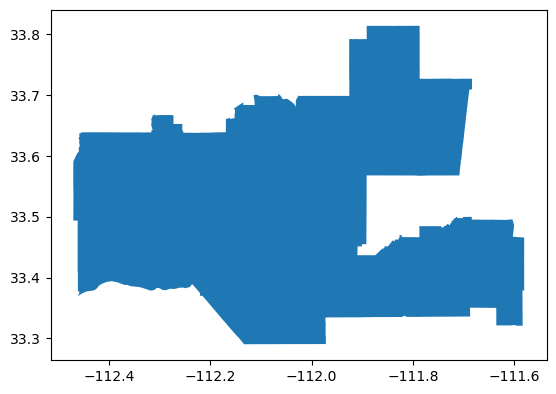

In [4]:
arizona.columns = arizona.columns.str.lower()

phoenix = arizona[arizona.name == "Phoenix"]

phoenix.plot()

Nice! We can use this county's geometries to mask our diversity data later on.

In [5]:
phoenix.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

- note: the CRS is EPSG:4269

## Map of Phoenix county

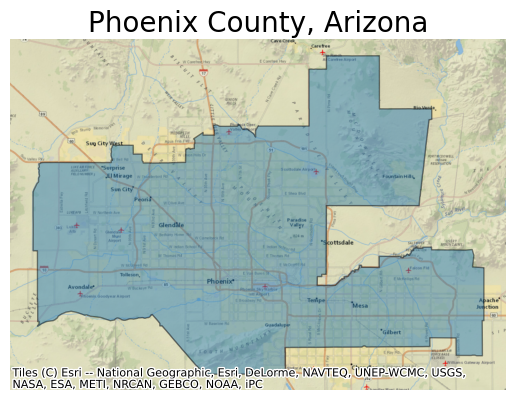

In [25]:
# set up figure
fig, ax = plt.subplots()

# create axis with plot
(phoenix.to_crs(epsg=3857) 
      .plot(ax=ax, figsize=(10, 10), alpha=0.45, edgecolor="k"))

# add NatGeo basemap from contextily
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Phoenix County, Arizona", fontdict= {"fontsize": "20"})
ax.set_axis_off()

# saving map as an image so we can input it elsewhere in our notebook
plt.savefig('figures/phoenix_county.png', bbox_inches = "tight", dpi = 100)

In [7]:
# selecting 2017 data
px_2017 = item_names['bii_2017_34.74464974521749_-115.38597824385106_cog']
px_2017

id: bii_2017_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2017-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2017-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


In [8]:
for key in px_2017.assets.keys():
    print(key, '--', px_2017.assets[key].title) 
# print key, separator, print / access the item assets of that key, get the title

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [9]:
# selecting 2020 data
px_2020 = item_names['bii_2020_34.74464974521749_-115.38597824385106_cog']
px_2020

id: bii_2020_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


Notice each item has a single asset, 'rendered preview', that contains an URL to the rendered preview / image of that particular file. They also have the asset "data", which includes the biodiversity data and also has an href that we can use to plot.

Let’s access each item’s data asset to plot:

In [10]:
# defining 2017 data asset
px_2017_preview = px_2017.assets["rendered_preview"]
px_2017_preview


href: https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png
type: image/png
title: Rendered preview
roles: ['overview']
owner: bii_2017_34.74464974521749_-115.38597824385106_cog
rel: preview


- note: we can use the href in this preview for a preliminary plot, which we'll also do for the "data" asset

In [11]:
# plot rendered preview
Image(url=px_2017_preview.href, width = 500)

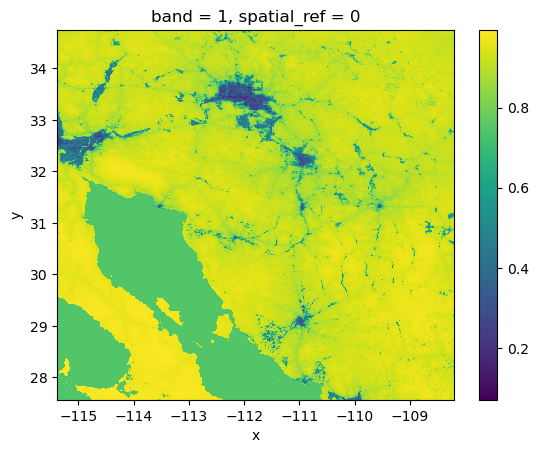

In [12]:
# retrieving 2017 biodiversity data and href to plot
px_2017_asset = px_2017.assets["data"]

px_2017_data = rioxr.open_rasterio(px_2017_asset.href)


px_2017_data.plot()

In [13]:
# defining 2020 data asset
px_2020_asset = px_2020.assets["data"]

px_2020_data = rioxr.open_rasterio(px_2020_asset.href)



In [14]:
px_2017_data.rio.crs

CRS.from_epsg(4326)

Note: this is different from our Phoenix shapefile CRS. Let's reproject our Phoenix shapefile to match the crs epsg 4326

In [15]:
phoenix = phoenix.to_crs(px_2017_data.rio.crs)

In [16]:
# check to see if the crs was properly updated
phoenix.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Great! Now we can move on to try to clip our 2017 Phoenix data to the geometry of Phoenix county.

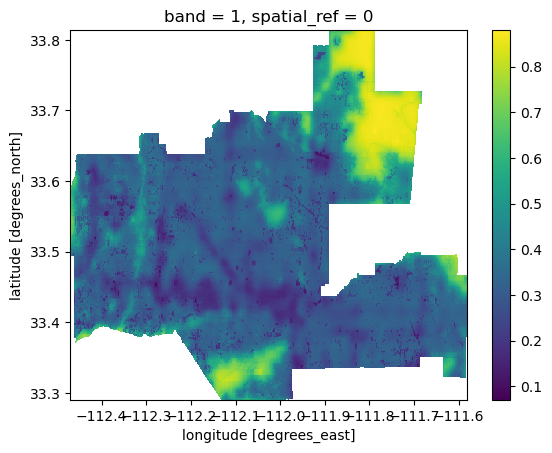

In [26]:
phoenix_clipped_2017 = px_2017_data.rio.clip(phoenix["geometry"])

phoenix_clipped_2017.plot()

By default, `contextily` uses the [OpenStreetMap HOT](http://map.hotosm.org/) style. We can change basemaps by updating the `source` parameter in the `add_basemap()` function. For example:

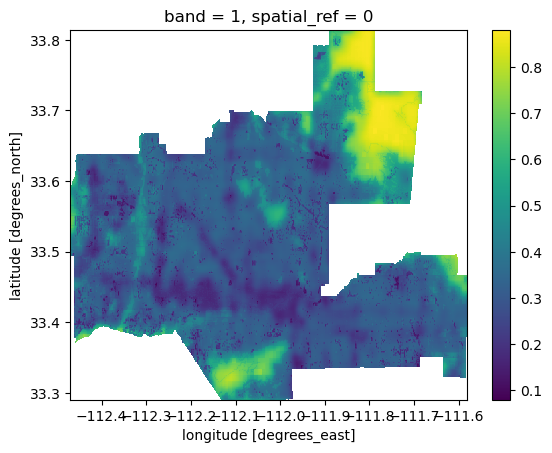

In [18]:
# performing this same step for the 2020 data:
phoenix_clipped_2020 =  px_2020_data.rio.clip(phoenix["geometry"])

phoenix_clipped_2020.plot()

In [19]:
# finding values where the BII was greater than or equal to 0.75 in 2017, classifying those cells as 1,
# everything at or below 0.75 classified as 0

phoenix_bii_2017 = (phoenix_clipped_2017 >= 0.75).astype(int)
phoenix_bii_2017

<xarray.DataArray (band: 1, y: 583, x: 990)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0

In [20]:
# doing the same for 2020 data
phoenix_bii_2020 = (phoenix_clipped_2020 >= 0.75).astype(int)
phoenix_bii_2020

<xarray.DataArray (band: 1, y: 583, x: 990)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -112.5 -112.5 -112.5 ... -111.6 -111.6 -111.6
  * y            (y) float64 33.81 33.81 33.81 33.81 ... 33.29 33.29 33.29 33.29
    spatial_ref  int64 0

Now, to find percentage area, we need to find the total area of our Phoenix subdivision and divide our pixels in the >0.75 class by that total area, then multiply by 100:

$ \frac{(pixels in class)}{(total pixels)} * 100 $,

where our "pixels in class" refer to the pixels with values of "1" in the objects we just defined above.


In [21]:
# finding total area for 2017 data:
# using .count() to count the number of pixels in the *polygon*, not the raster (.sum())
total_area_2017 = phoenix_clipped_2017.count().item() # using .item() to access just the value

# and total area for 2020 data:
total_area_2020 = phoenix_clipped_2020.count().item()

In [22]:
# finding the total area in the bii > 0.75 class for 2017 data:
# using .sum() here to total up the number of pixels in the polygon that meet our condition
pixels_in_class_2017 = phoenix_bii_2017.sum().item() # using .item() to access just the value

# and for 2020:
pixels_in_class_2020 = phoenix_bii_2020.sum().item()

In [23]:
# calculating the percentage area for 2017 data:
pct_bii_2017 =  (pixels_in_class_2017 / total_area_2017) * 100

# and percentage area for 2020 data:

pct_bii_2020 = (pixels_in_class_2020 / total_area_2020) * 100


In [29]:
# viewing percentages:

pct_text = "The percentage of area in Phoenix County with a BII over 0.75 in"
print(pct_text, "2017 is: ", round(pct_bii_2017, 2), "%")

print(pct_text, "2020 is: ", round(pct_bii_2020, 2), "%")

The percentage of area in Phoenix County with a BII over 0.75 in 2017 is:  7.13 %
The percentage of area in Phoenix County with a BII over 0.75 in 2020 is:  6.49 %


## Visualizing Biodiversity Intactness Index values greater than or equal to 0.75 in Phoenix

Now that we've found and classified the areas where the BII >= 0.7 in 2017 and 2020, we can visualize these changes over time. We'll make a map of our 2020 BII data and Phoenix polygon, highlighting areas (pixels) where there was a loss in BII from 2017 to 2020. 

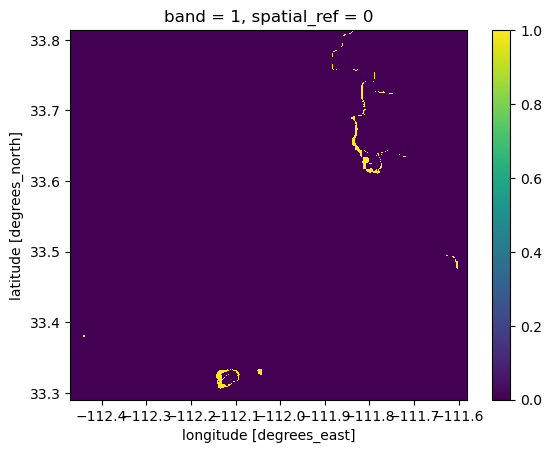

In [35]:
# first, we'll find areas where there was a loss in BII from 2017 to 2020
phx_bii_diff = phoenix_bii_2017 - phoenix_bii_2020

# to make our mask, we'll need to select pixels where the difference == 1
# basically, pixels that were BII >= 0.75 in 2017, but NOT in 2020, 
# will be selected because those are areas where there was BII loss
phx_bii_loss = phx_bii_diff == 1

# converting from boolean to integer for easier plotting and manipulation later
phx_bii_loss = phx_bii_loss.astype(int)

# plotting 
phx_bii_loss.plot()

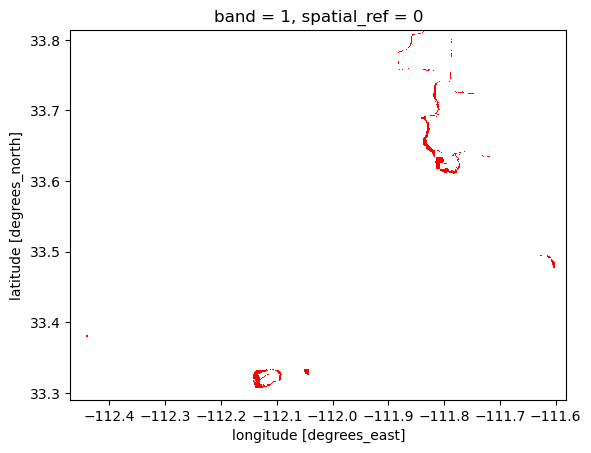

In [38]:
# let's customize this mask and recolor our BII loss areas for emphasis:
color_id = ["none", # set non-1 values to be transparent
            "red"] # color loss areas red

# creating a colormap object, feeding it our list of colors
cmap = plt.cm.colors.ListedColormap(color_id)

# let's check to see if our mask was successfully customized:
phx_bii_loss.plot(cmap = cmap, add_colorbar = False)

Great! Let's make our final visualization.

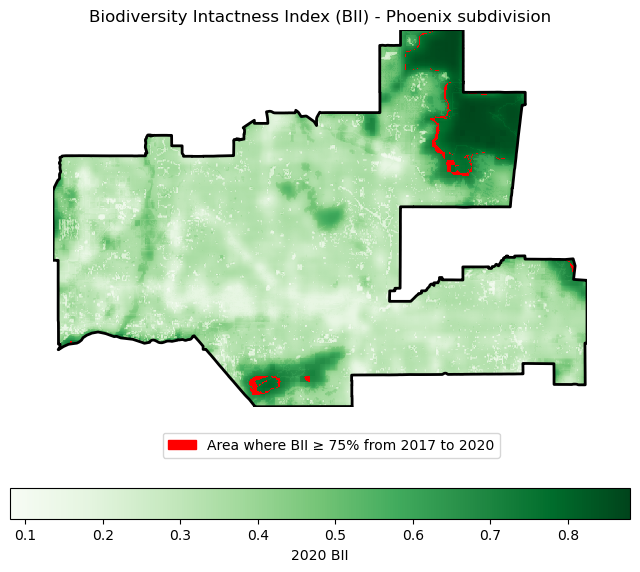

<Figure size 640x480 with 0 Axes>

In [49]:
# BII loss visualization

# ======= Initialize plot ======== #
fig, ax = plt.subplots(figsize = (8, 7))

# remove axes for a cleaner plot
ax.axis("off")


# ======= Phoenix 2020 BII Raster layer ========== #
phoenix_clipped_2020.plot(ax = ax,  # share axes 
                          cmap = "Greens", 
                          cbar_kwargs = {"location": "bottom", # for intuitive biodiversity sense
                                       "label": "2020 BII"}) 


# ======= BII Loss layer ======== #

phx_bii_loss.plot(ax = ax, # share axes
                  cmap = cmap, # our predefined colormap object
                  add_colorbar = False # we're going to make a custom legend, so we don't want the default one
                  )

phx_bii_loss_patch = mpatches.Patch(color = "red",
                                   label = "Area where BII ≥ 75% from 2017 to 2020")


# ======= Phoenix polygon outline layer ====== #
phoenix.plot(ax = ax, # share axes (on the same plot as everything else)
             color = "none", # transparent fill
             edgecolor = "black",
             linewidth = 2
            )


# ======= Customizing our map ======== #

# update legend, add in BII loss patch
ax.legend(handles = [phx_bii_loss_patch],
          bbox_to_anchor = (0.85, -0.05))

# update title
ax.set_title("Biodiversity Intactness Index (BII) - Phoenix subdivision")

# view plot
plt.show()

# Save figure as image to figures folder
plt.savefig('figures/bii_phoenix_final.png', bbox_inches = 'tight', dpi = 100)